In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp

In [3]:
# conda install -c conda-forge scikit-surprise

import surprise

In [5]:
# 데이터 준비 : MovieLense, 10만개 로드

data = surprise.Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to C:\Users\choeu/.surprise_data/ml-100k


In [ ]:
# 데이터프레임으로 변환

In [6]:
df = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rate", "id"])
del df['id']
df.head(10)

user item  rate
0  196  242   3.0
1  186  302   3.0
2   22  377   1.0
3  244   51   2.0
4  166  346   1.0
5  298  474   4.0
6  115  265   2.0
7  253  465   5.0
8  305  451   3.0
9    6   86   3.0

In [ ]:
# 피봇하여 x축이 상품, y축이 사용자 아이디인 평점 행렬(rate matrix) R 생성

In [7]:
df_table = df.set_index(["user", "item"]).unstack()
df_table.shape

(943, 1682)

In [ ]:
# 행렬 살펴보기

In [8]:
df_table.iloc[212:222, 808:817].fillna("")

# 평점 데이터가 일부 위치에만 존재하는 sparse 행렬임

rate                                        
item  211  212  213  214  215  216  217  218  219
user                                             
290   3.0                      4.0       2.0     
291        4.0       4.0  4.0            4.0  4.0
292                  3.0                         
293   4.0       3.0       4.0  4.0  3.0  2.0     
294                                              
295             5.0       5.0  5.0  4.0  5.0     
296   4.0                                        
297   4.0       3.0       2.0  4.0       3.0     
298   5.0       3.0       5.0                    
299   4.0  4.0  5.0            5.0

In [ ]:
# 평점 행렬의 빈칸을 흰색, 점수를 검은색으로 시각화

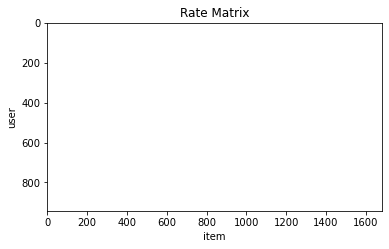

In [11]:
plt.imshow(df_table)
plt.grid(False)
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rate Matrix")
plt.show();

In [ ]:
# 추천 성능 평가

In [12]:
from surprise.model_selection import KFold

bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
algo = surprise.BaselineOnly(bsl_options)

np.random.seed(0)
acc = np.zeros(3)
cv = KFold(3)
for i, (trainset, testset) in enumerate(cv.split(data)):
    algo.fit(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.rmse(predictions, verbose=True)
acc.mean()

Estimating biases using als...
RMSE: 0.9453
Estimating biases using als...
RMSE: 0.9377
Estimating biases using als...
RMSE: 0.9500


0.9443304984013942

In [ ]:
# cross_validate 명령을 사용하면 위 코드를 다음과 같이 단축

In [13]:
from surprise.model_selection import cross_validate

cross_validate(algo, data)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.9384446 , 0.94651657, 0.93612815, 0.94221861, 0.94428787]),
 'test_mae': array([0.74477853, 0.75124267, 0.73975393, 0.745764  , 0.74659098]),
 'fit_time': (0.15290355682373047,
  0.16889262199401855,
  0.19087839126586914,
  0.17162203788757324,
  0.17288923263549805),
 'test_time': (0.16789627075195312,
  0.42073941230773926,
  0.15190649032592773,
  0.25884103775024414,
  0.15790414810180664)}

In [ ]:
# 평균제곱차이 유사도

In [14]:
sim_options = {'name': 'msd'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


0.7726801901092284

In [ ]:
# 코사인 유사도

In [15]:
sim_options = {'name': 'cosine'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


0.8046567723959086

In [ ]:
# 피어슨 유사도

In [16]:
sim_options = {'name': 'pearson'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


0.8032778978216127

In [ ]:
# 피어슨 베이스라인 유사도

In [17]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


0.791677323191221

In [ ]:
# KNN(K Nearest Neighbors)

In [18]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNWithMeans(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


0.7299485648439766

In [19]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBaseline(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


0.7211170375266851